In [ ]:
# Import necessary libraries
import os
import json
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from scipy.stats import boxcox
import warnings

# Scikit-learn imports
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    KFold,
)
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, LocalOutlierFactor
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    VotingClassifier,
    StackingClassifier,
)
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, RobustScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV

In [ ]:
warnings.simplefilter(action='ignore')
sns.set_theme()
plt.style.use("ggplot")

# For reproducibility
RANDOM_STATE = 42

### ---------------------------
### 1. Data Loading & EDA
### ---------------------------

In [47]:
df = pd.read_csv("diabetes.csv")

#### Context
<p>Ce jeu de données provient à l'origine de l'Institut national du diabète et des maladies digestives et rénales. L'objectif est de prédire, à partir de mesures diagnostiques, si un patient est diabétique.</p>

#### Content
<p>Plusieurs contraintes ont été imposées pour la sélection de ces instances à partir d'une base de données plus large. En particulier, toutes les patientes ici sont des femmes d'au moins 21 ans d'origine indienne Pima.</p>


<ul>
  <li>Pregnancies: Nombre de fois enceinte</li>
  <li>Glucose: Concentration de glucose plasmatique 2 heures après un test de tolérance au glucose par voie orale</li>
  <li>BloodPressure: Pression artérielle diastolique (mm Hg)</li>
  <li>SkinThickness: Épaisseur du pli cutané tricipital (mm)</li>
  <li>Insulin: Insuline sérique 2 heures (mu U/ml)</li>
  <li>BMI: Indice de masse corporelle (poids en kg/(taille en m)^2)</li>
  <li>DiabetesPedigreeFunction: Fonction pédigrée du diabète</li>
  <li>Age: Age (années)</li>
  <li>Outcome: Variable de classe (0 ou 1)</li>
</ul>

In [ ]:
# Preview the data
df.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            2      168             90             43      574  35.9   
1           11      178             84             45      215  37.7   
2            1      142             74              0        0  44.0   
3            5      126             54             15      125  25.2   
4            4      157             72             39      258  40.6   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.585   29        1  
1                     0.905   48        1  
2                     0.935   45        0  
3                     1.181   31        0  
4                     0.414   29        1

In [ ]:
# Display information about data types and null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               99999 non-null  int64  
 1   Glucose                   99999 non-null  int64  
 2   BloodPressure             99999 non-null  int64  
 3   SkinThickness             99999 non-null  int64  
 4   Insulin                   99999 non-null  int64  
 5   BMI                       99999 non-null  float64
 6   DiabetesPedigreeFunction  99998 non-null  float64
 7   Age                       99999 non-null  int64  
 8   Outcome                   99999 non-null  int64  
dtypes: float64(2), int64(7)
memory usage: 6.9 MB


In [50]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [ ]:
# descriptive statistics of the dataset
df.describe()

Pregnancies       Glucose  BloodPressure  SkinThickness       Insulin  \
count  99999.000000  99999.000000   99999.000000   99999.000000  99999.000000   
mean       3.718267    121.991130      70.286893      21.608726     80.384034   
std        3.464713     27.983126      15.691992      15.228838    104.016432   
min        0.000000      0.000000       0.000000       0.000000      0.000000   
25%        1.000000    103.000000      64.000000       0.000000      0.000000   
50%        3.000000    119.000000      72.000000      25.000000     49.000000   
75%        6.000000    139.000000      78.000000      33.000000    140.000000   
max       17.000000    199.000000     122.000000      95.000000    714.000000   

                BMI  DiabetesPedigreeFunction           Age       Outcome  
count  99999.000000              99998.000000  99999.000000  99999.000000  
mean      32.370817                  0.436068     32.216502      0.377834  
std        7.106102                  0.276450     10.734385      0.484848  
min        0.000000                  0.078000     21.000000      0.000000  
25%       27.600000                  0.238000     24.000000      0.000000  
50%       32.800000                  0.347000     28.000000      0.000000  
75%       36.800000                  0.584000     40.000000      1.000000  
max       63.200000                  2.342000     81.000000      1.000000

In [ ]:
# Check the shape of the dataset (rows, columns)
df.shape

(99999, 9)

In [ ]:
# Check the distribution of the outcome variable
print("Outcome distribution (%):")
print((df["Outcome"].value_counts(normalize=True) * 100))

Outcome distribution (%):
Outcome
0    62.216622
1    37.783378
Name: proportion, dtype: float64


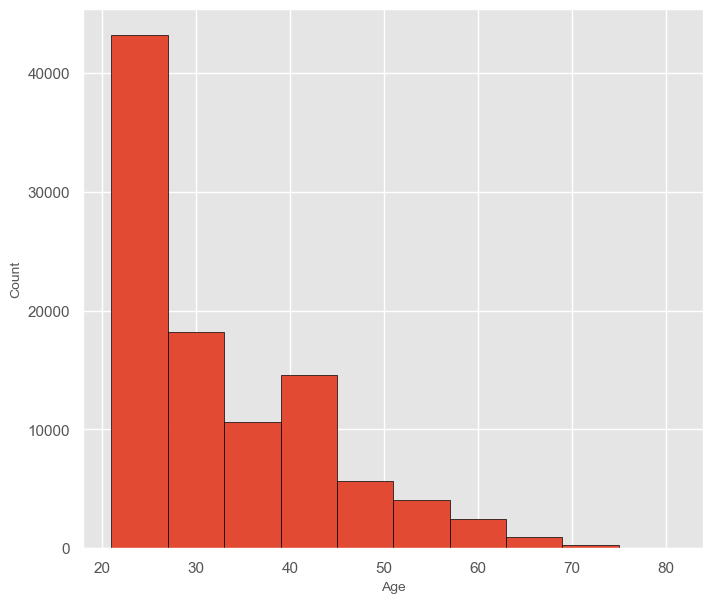

In [ ]:
# Plot a histogram of the 'Age' feature
plt.figure(figsize=(8,7))
plt.xlabel('Age', fontsize=10)
plt.ylabel('Count', fontsize=10)
df['Age'].hist(edgecolor="black")
plt.show()

In [ ]:
# Print the max and min age
print("MAX AGE: "+str(df['Age'].max()))
print("MIN AGE: "+str(df['Age'].min()))

MAX AGE: 81
MIN AGE: 21


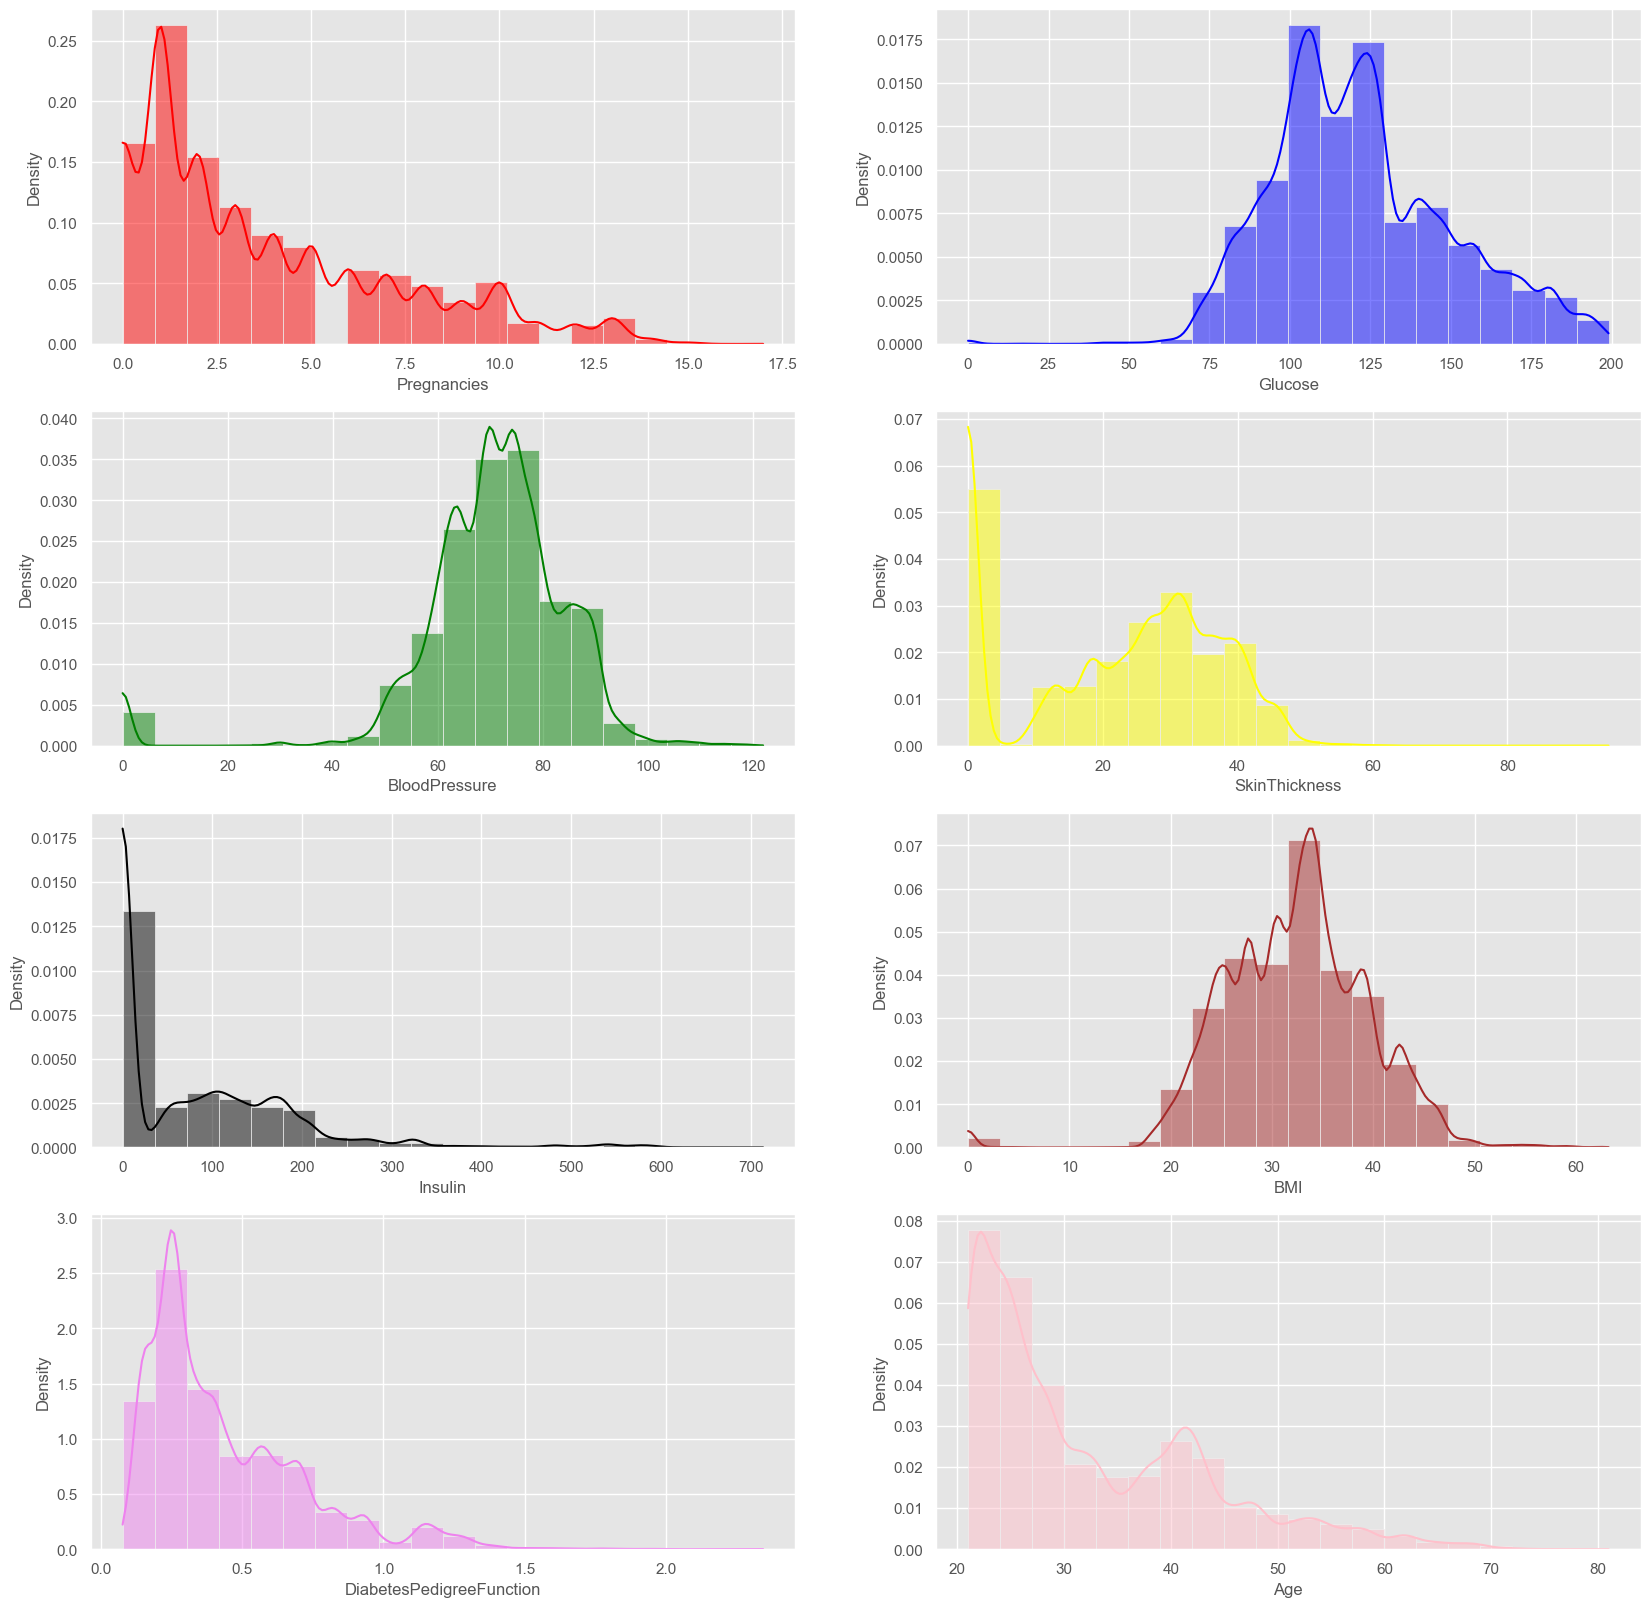

In [ ]:
# Plot density graphs for all numerical features

fig, ax = plt.subplots(4, 2, figsize=(20, 20))
features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
colors = ["red", "blue", "green", "yellow", "black", "brown", "violet", "pink"]

for i, feature in enumerate(features):
    sns.histplot(df[feature], bins=20, ax=ax[i//2, i%2], color=colors[i], kde=True, stat="density")
plt.show()

In [ ]:
def group_stats(df, feature_list, outcome_col='Outcome'):
    """Computes mean and max for given features grouped by outcome."""
    return df.groupby(outcome_col)[feature_list].agg(['mean', 'max'])

grouped_features = group_stats(df, ['Pregnancies', 'Glucose'])

In [ ]:
# Homework
# 'BloodPressure', 'SkinThickness', 'Insulin',
#        'BMI', 'DiabetesPedigreeFunction', 'Age'
#     groupby-> mean/max

# 0>healthy
# 1>diabetes

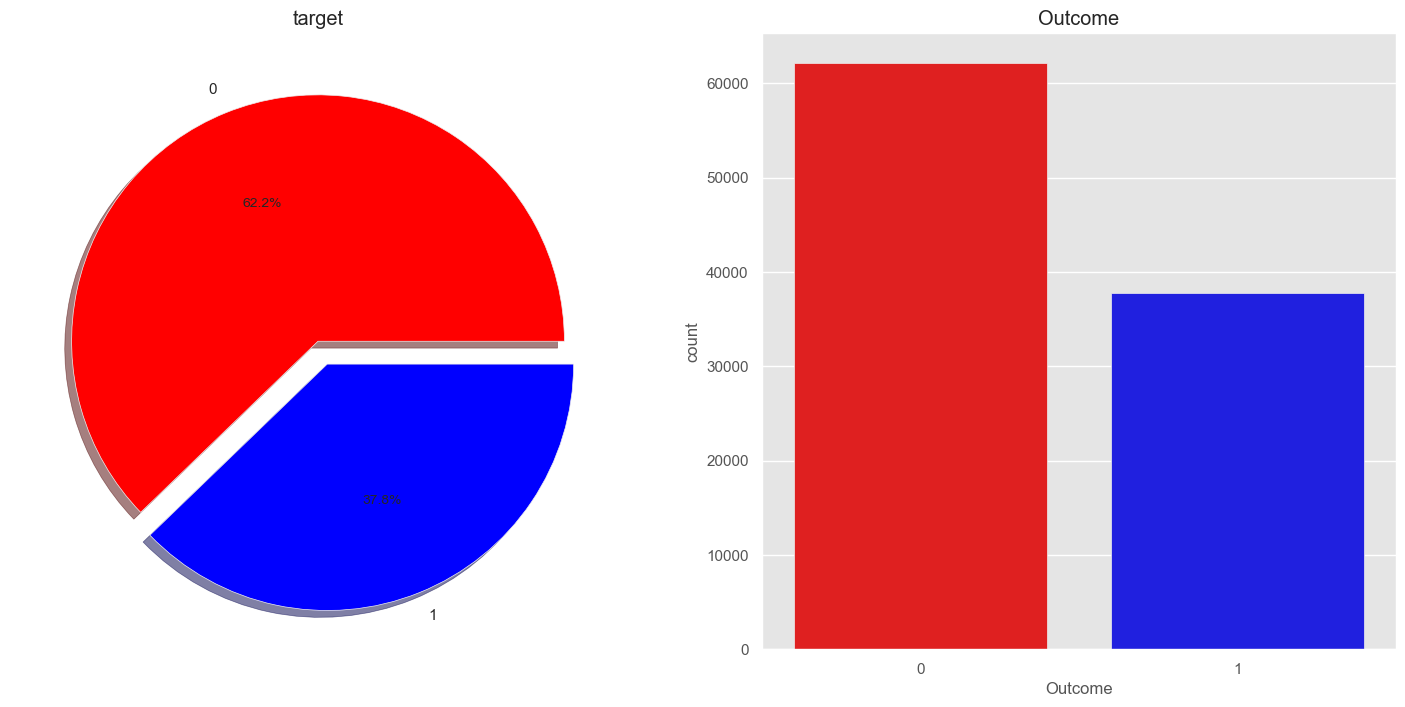

In [ ]:
"""
This code snippet creates a subplot with two visualizations to analyze the 'Outcome' column in a DataFrame `df`.

The first subplot is a pie chart that shows the distribution of the 'Outcome' values, with the following properties:
- Explodes the second slice slightly for emphasis.
- Displays the percentage of each slice.
- Uses a shadow effect.
- Colors the slices red and blue.

The second subplot is a count plot that shows the count of each 'Outcome' value, with the following properties:
- Uses a red and blue color palette.

Both subplots have titles, and the first subplot has an empty y-label.

Parameters:
- df (DataFrame): The DataFrame containing the 'Outcome' column to be visualized.

Returns:
- None: This function does not return any value. It displays the plots directly.
"""
f, ax = plt.subplots(1, 2, figsize=(18, 8))
df['Outcome'].value_counts().plot.pie(
    explode=[0, 0.1],
    autopct="%1.1f%%",
    ax=ax[0],
    shadow=True,
    colors=['red', 'blue']
)
ax[0].set_title('target')
ax[0].set_ylabel('')
sns.countplot(
    x='Outcome',
    data=df,
    ax=ax[1],
    palette=['red', 'blue']
)
ax[1].set_title('Outcome')
plt.show()

In [ ]:
df.corr()
"""
Calculates the correlation matrix for the DataFrame `df`.

Returns:
  DataFrame: A DataFrame containing the correlation coefficients between the columns of `df`.
"""

'\nCalculates the correlation matrix for the DataFrame `df`.\n\nReturns:\n  DataFrame: A DataFrame containing the correlation coefficients between the columns of `df`.\n'

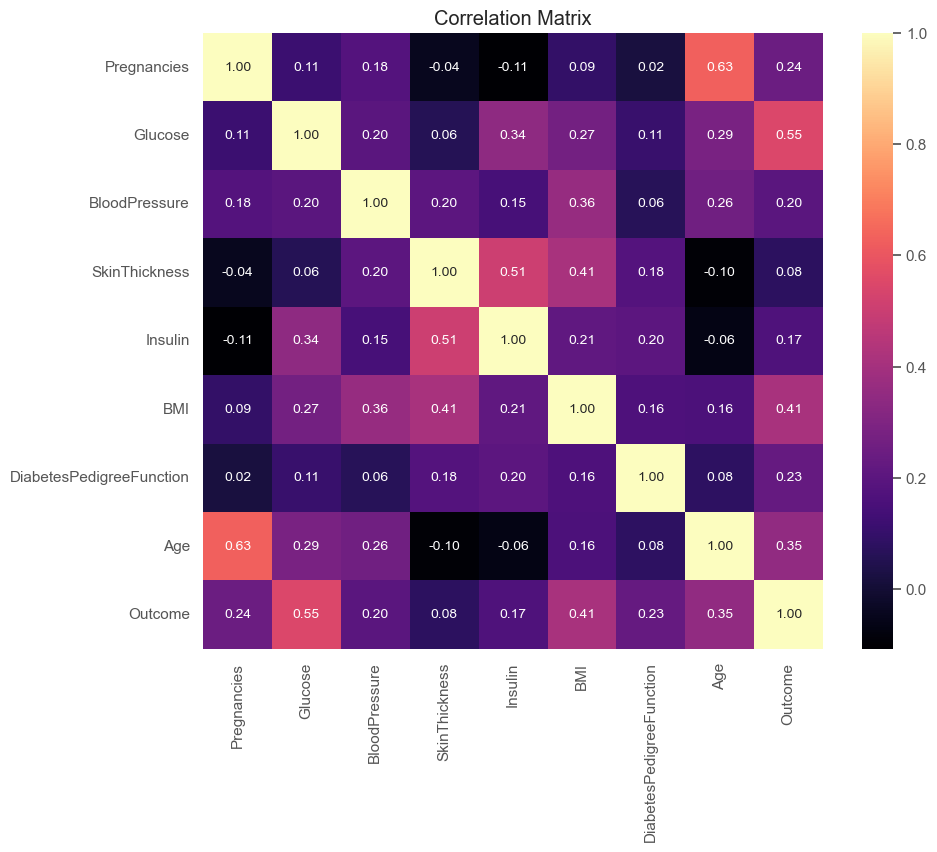

In [ ]:
# Check correlation between features using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="magma")
plt.title("Correlation Matrix")
plt.show()

### Exploratory Data Analysis(EDA) Part Completed


In [62]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

### ---------------------------
### 2. Data Preprocessing
### ---------------------------

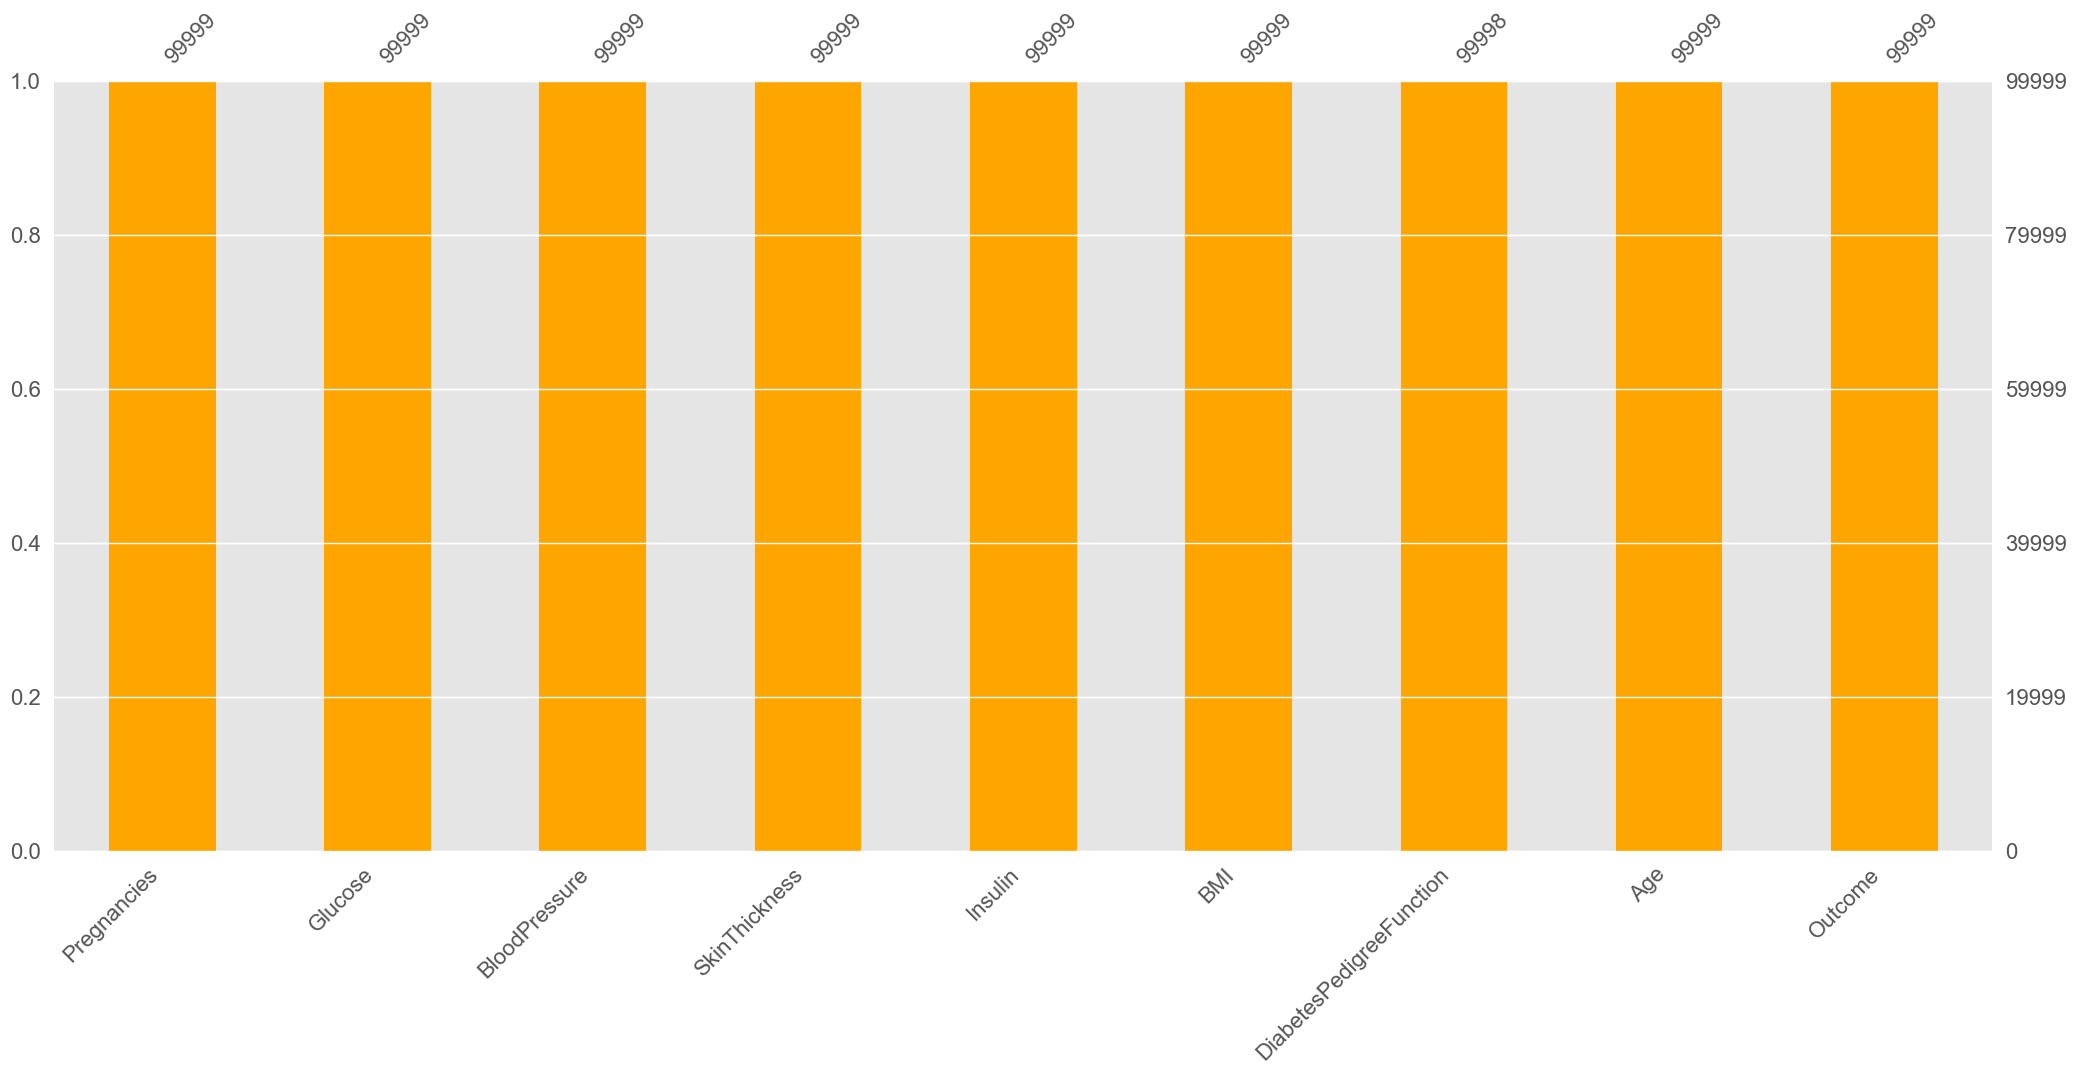

In [ ]:
# Visualize missing values
import missingno as msno
msno.bar(df, color="orange")
plt.show()

In [ ]:
def replace_zeros(data, columns):
    data[columns] = data[columns].replace(0, np.nan)
    return data


zero_columns = [
    "Pregnancies",
    "Glucose",
    "BloodPressure",
    "SkinThickness",
    "Insulin",
    "BMI",
]
df = replace_zeros(df, zero_columns)

In [ ]:
# Impute missing values using median values grouped by Outcome
for col in df.columns.drop("Outcome"):
    medians = df.groupby("Outcome")[col].median()
    df.loc[(df["Outcome"] == 0) & (df[col].isnull()), col] = medians.loc[0]
    df.loc[(df["Outcome"] == 1) & (df[col].isnull()), col] = medians.loc[1]

In [ ]:
# Check missing values
print("Missing values after imputation:")
print(df.isnull().sum())

Missing values after imputation:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


In [67]:
df.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0          2.0    168.0           90.0           43.0    574.0  35.9   
1         11.0    178.0           84.0           45.0    215.0  37.7   
2          1.0    142.0           74.0           27.0    105.0  44.0   
3          5.0    126.0           54.0           15.0    125.0  25.2   
4          4.0    157.0           72.0           39.0    258.0  40.6   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.585   29        1  
1                     0.905   48        1  
2                     0.935   45        0  
3                     1.181   31        0  
4                     0.414   29        1

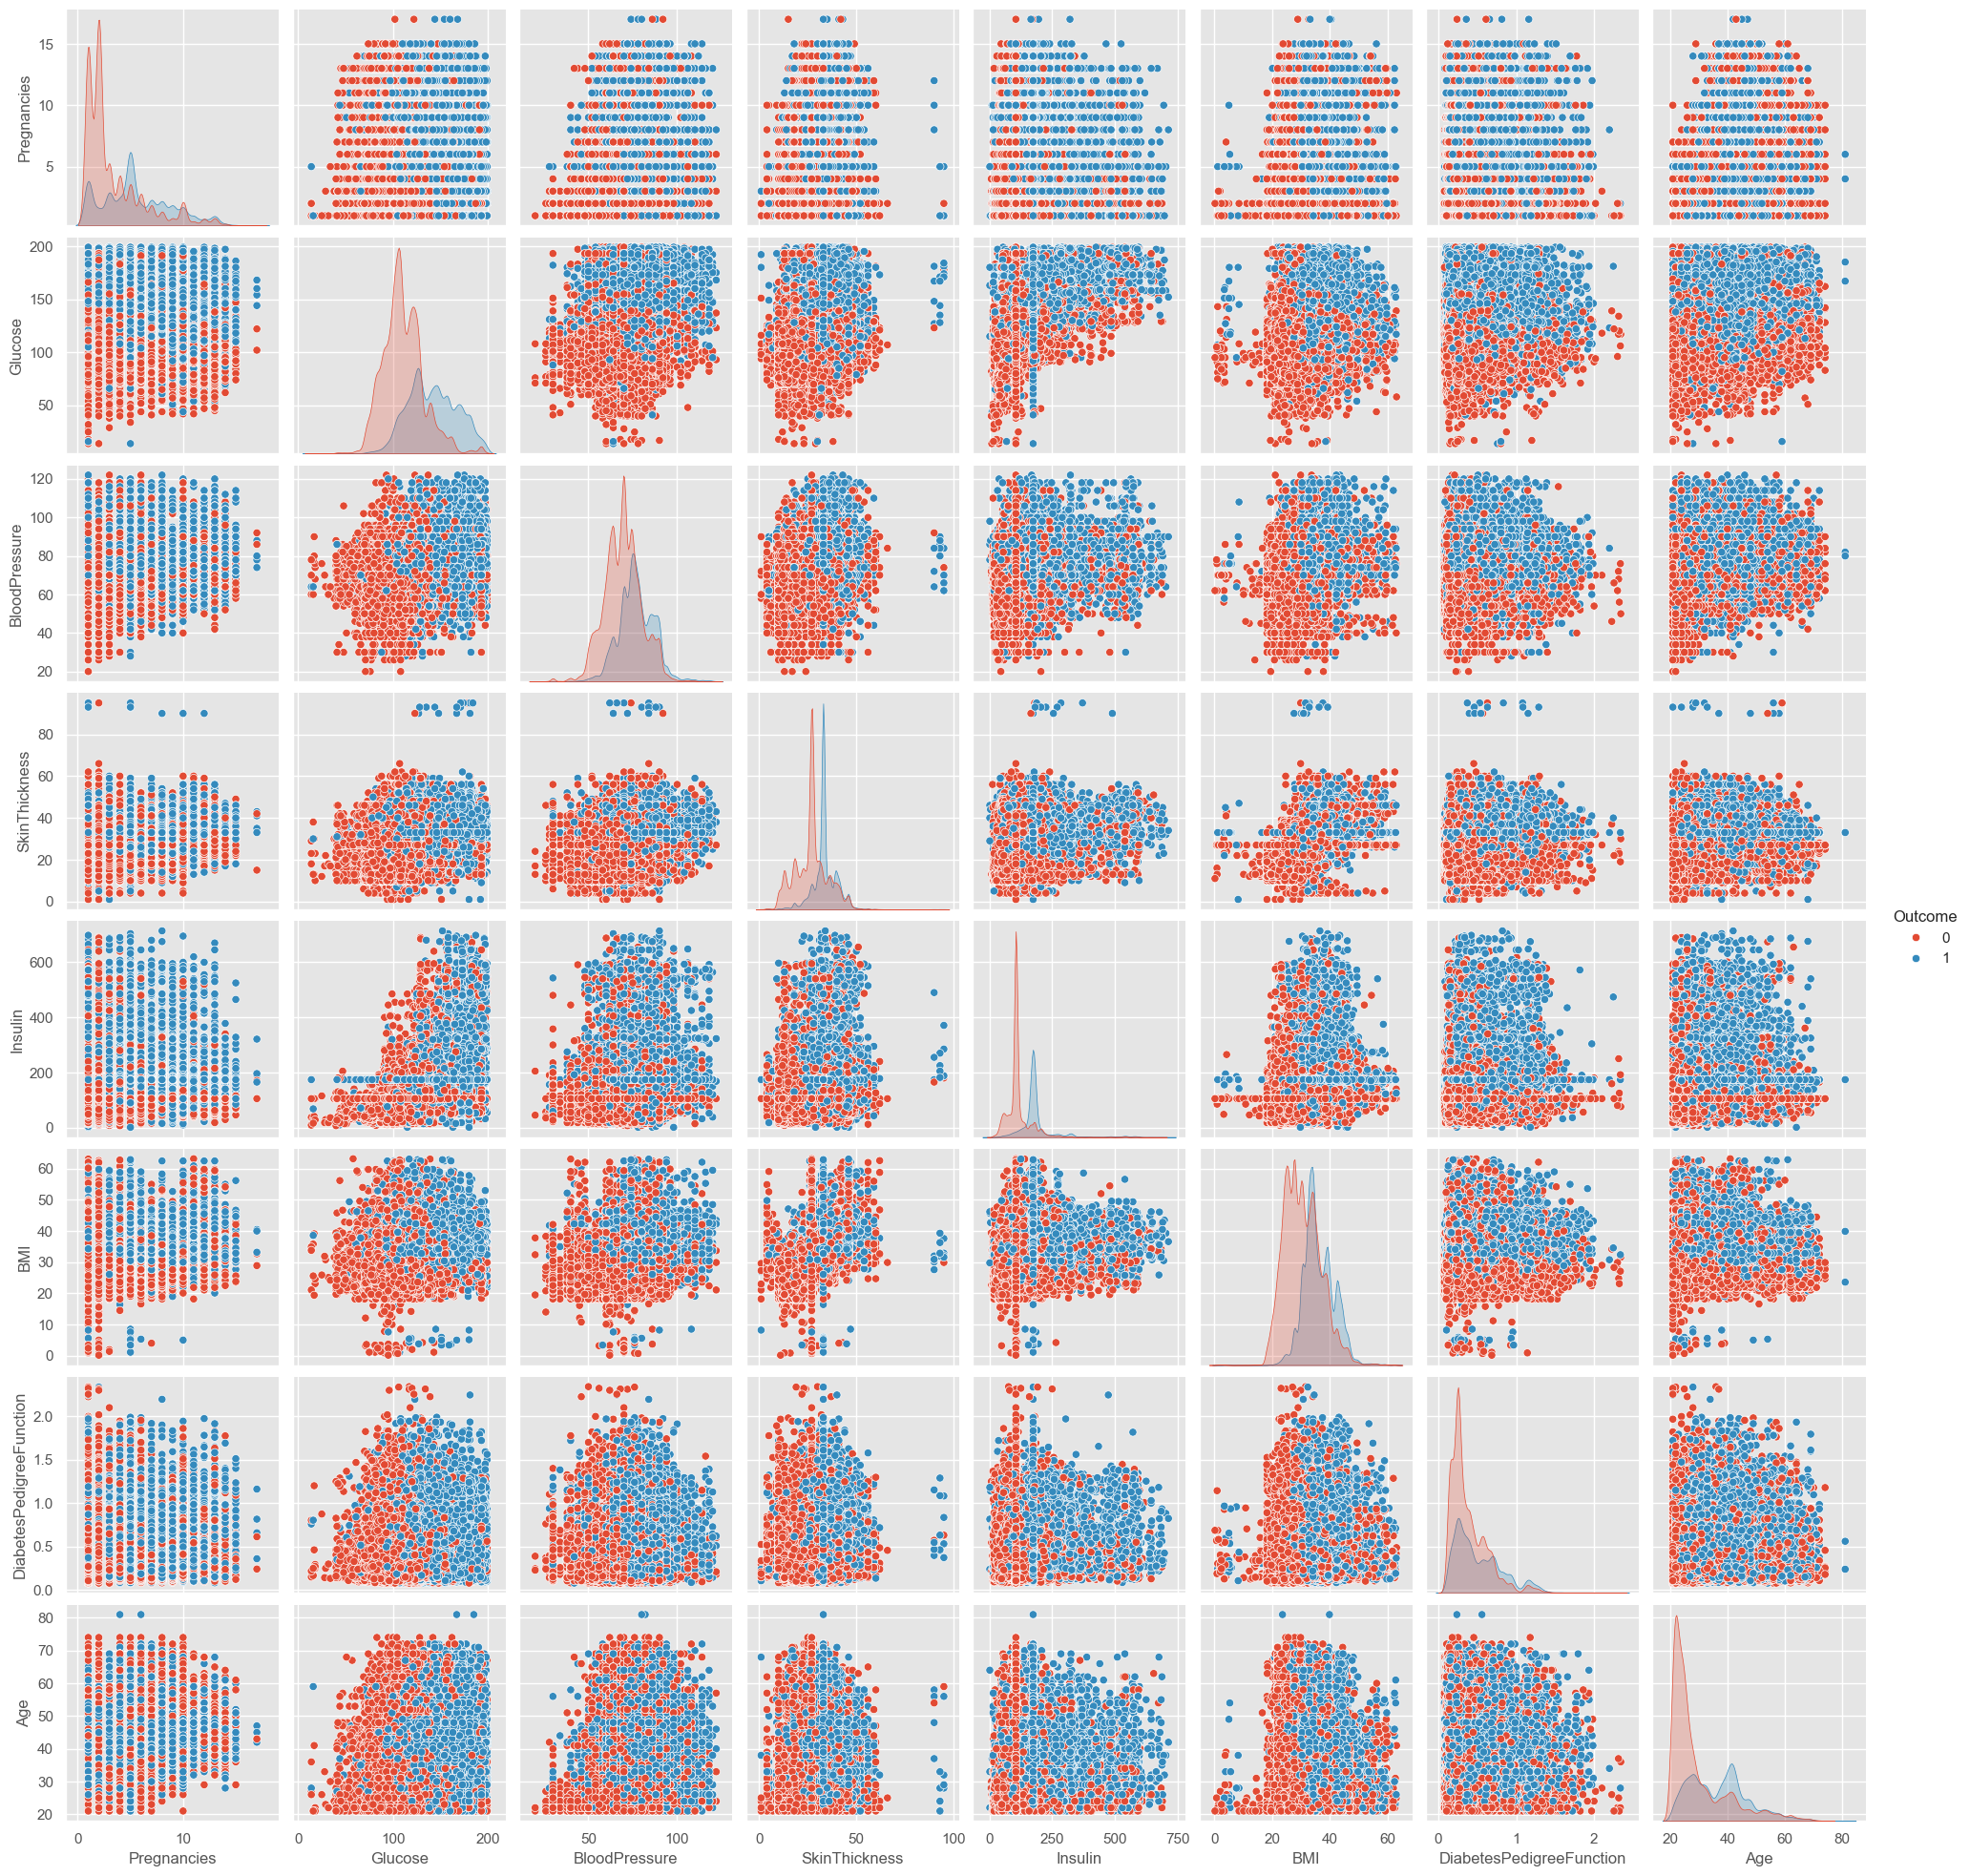

In [ ]:
# Pairplot to explore relationships between features and the target variable
p = sns.pairplot(df, hue="Outcome")
plt.show()

In [ ]:
# Cap outliers using IQR method for continuous variables
def cap_outliers(data, cols, threshold=1.5):
    for col in cols:
        Q1, Q3 = data[col].quantile([0.25, 0.75])
        IQR = Q3 - Q1
        lower, upper = Q1 - threshold * IQR, Q3 + threshold * IQR
        data[col] = np.clip(data[col], lower, upper)
    return data


cont_cols = [
    "Pregnancies",
    "Glucose",
    "BloodPressure",
    "SkinThickness",
    "Insulin",
    "BMI",
    "DiabetesPedigreeFunction",
    "Age",
]
df = cap_outliers(df, cont_cols)

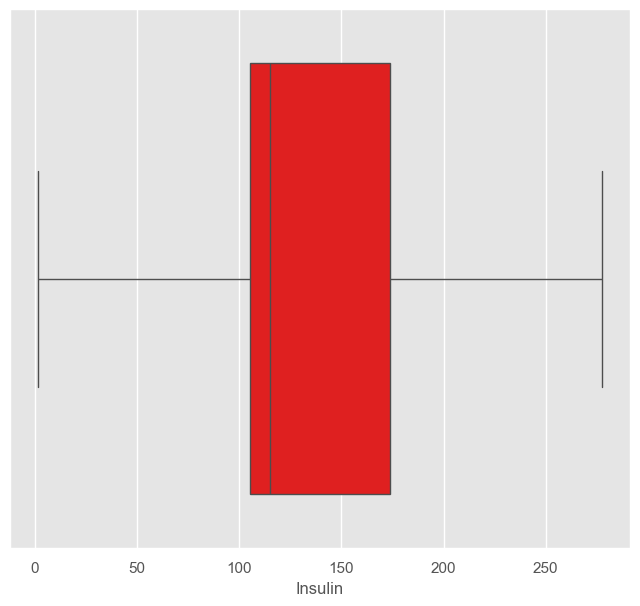

In [ ]:
# Visualize outliers for 'Insulin'
plt.figure(figsize=(8,7))
sns.boxplot(x= df["Insulin"], color="red")
plt.show()

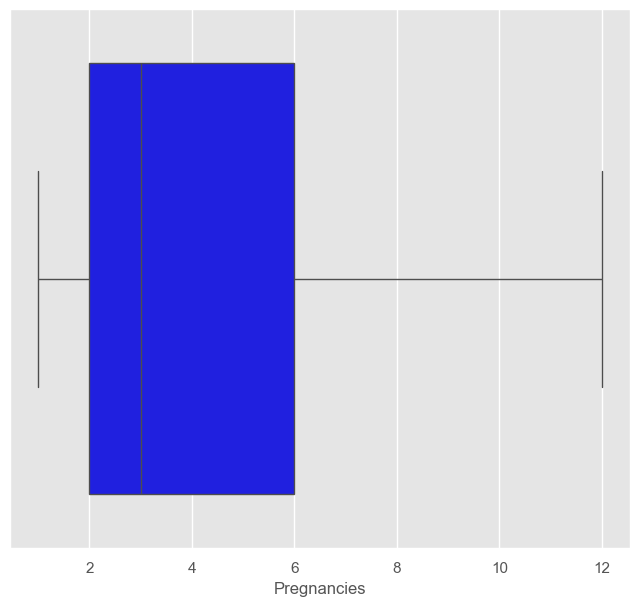

In [ ]:
plt.figure(figsize=(8,7))
sns.boxplot(x= df["Pregnancies"], color="blue")
plt.show()

In [72]:
df.shape

(99999, 9)

### ---------------------------
### 3. Feature Engineering
### ---------------------------

In [ ]:
# Categorize BMI into groups (we then later one-hot encode these)
def categorize_bmi(bmi):
    if bmi < 18.5:
        return "Underweight"
    elif bmi <= 24.9:
        return "Normal"
    elif bmi <= 29.9:
        return "Overweight"
    elif bmi <= 34.9:
        return "Obesity1"
    elif bmi <= 39.9:
        return "Obesity2"
    else:
        return "Obesity3"


df["BMI_Category"] = df["BMI"].apply(categorize_bmi)

In [74]:
df.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0          2.0    168.0           90.0           43.0    277.5  35.9   
1         11.0    178.0           84.0           43.5    215.0  37.7   
2          1.0    142.0           74.0           27.0    105.0  44.0   
3          5.0    126.0           54.0           15.5    125.0  25.2   
4          4.0    157.0           72.0           39.0    258.0  40.6   

   DiabetesPedigreeFunction  Age  Outcome BMI_Category  
0                     0.585   29        1     Obesity2  
1                     0.905   48        1     Obesity2  
2                     0.935   45        0     Obesity3  
3                     1.103   31        0   Overweight  
4                     0.414   29        1     Obesity3

In [ ]:
# Categorize Insulin levels
def insulin_category(ins):
    return "Normal" if 16 <= ins <= 166 else "Abnormal"


df["Insulin_Category"] = df["Insulin"].apply(insulin_category)

In [76]:
df.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0          2.0    168.0           90.0           43.0    277.5  35.9   
1         11.0    178.0           84.0           43.5    215.0  37.7   
2          1.0    142.0           74.0           27.0    105.0  44.0   
3          5.0    126.0           54.0           15.5    125.0  25.2   
4          4.0    157.0           72.0           39.0    258.0  40.6   

   DiabetesPedigreeFunction  Age  Outcome BMI_Category Insulin_Category  
0                     0.585   29        1     Obesity2         Abnormal  
1                     0.905   48        1     Obesity2         Abnormal  
2                     0.935   45        0     Obesity3           Normal  
3                     1.103   31        0   Overweight           Normal  
4                     0.414   29        1     Obesity3         Abnormal

In [ ]:
# Categorize Glucose levels
def glucose_category(gluc):
    if gluc <= 70:
        return "Low"
    elif gluc <= 99:
        return "Normal"
    elif gluc <= 126:
        return "Overweight"
    else:
        return "Secret"


df["Glucose_Category"] = df["Glucose"].apply(glucose_category)

In [78]:
df.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0          2.0    168.0           90.0           43.0    277.5  35.9   
1         11.0    178.0           84.0           43.5    215.0  37.7   
2          1.0    142.0           74.0           27.0    105.0  44.0   
3          5.0    126.0           54.0           15.5    125.0  25.2   
4          4.0    157.0           72.0           39.0    258.0  40.6   

   DiabetesPedigreeFunction  Age  Outcome BMI_Category Insulin_Category  \
0                     0.585   29        1     Obesity2         Abnormal   
1                     0.905   48        1     Obesity2         Abnormal   
2                     0.935   45        0     Obesity3           Normal   
3                     1.103   31        0   Overweight           Normal   
4                     0.414   29        1     Obesity3         Abnormal   

  Glucose_Category  
0           Secret  
1           Secret  
2           Secret  
3       Overweight  
4           Secret

In [ ]:
# One-hot encode the new categorical features
df = pd.get_dummies(
    df,
    columns=["BMI_Category", "Insulin_Category", "Glucose_Category"],
    drop_first=True,
)

#### ---------------------------
#### 4. Prepare Data for Modeling
#### ---------------------------

In [ ]:
# Separate target and features
y = df["Outcome"]
X = df.drop(["Outcome"], axis=1)

In [ ]:
# Split data into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

### ---------------------------
### 5. Building Pipelines and Models
### ---------------------------


In [ ]:
# Here we use StandardScaler. If you want polynomial features, you can add that step.
preprocessor = Pipeline(
    [
        ("scaler", StandardScaler()),
    ]
)

In [ ]:
# Example models and hyperparameter grids
param_grid_lr = {"clf__C": [0.01, 0.1, 1, 10, 100], "clf__penalty": ["l1", "l2"]}

pipe_lr = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("clf", LogisticRegression(solver="liblinear", random_state=RANDOM_STATE)),
    ]
)

grid_lr = GridSearchCV(pipe_lr, param_grid_lr, cv=5, scoring="accuracy", n_jobs=-1)
grid_lr.fit(X_train, y_train)
print("Best Logistic Regression Params:", grid_lr.best_params_)
print("Logistic Regression CV Accuracy:", grid_lr.best_score_)

Best Logistic Regression Params: {'clf__C': 0.01, 'clf__penalty': 'l2'}
Logistic Regression CV Accuracy: 0.8814985413150822


In [ ]:
# Similarly, set up a tuned SVM pipeline (example tuning)
param_grid_svc = {"clf__C": [0.1, 1], "clf__gamma": [0.001, 0.0]}

pipe_svc = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("clf", SVC(probability=True, random_state=RANDOM_STATE)),
    ]
)

grid_svc = GridSearchCV(pipe_svc, param_grid_svc, cv=3, scoring="accuracy", n_jobs=-1,refit=True)
grid_svc.fit(X_train, y_train)
print("Best SVC Params:", grid_svc.best_params_)
print("SVC CV Accuracy:", grid_svc.best_score_)

In [ ]:
# Train additional models (Decision Tree, KNN, RandomForest, GradientBoosting, XGBoost)
dt = DecisionTreeClassifier(random_state=RANDOM_STATE)
dt.fit(preprocessor.fit_transform(X_train), y_train)
knn = KNeighborsClassifier()
knn.fit(preprocessor.fit_transform(X_train), y_train)
rf = RandomForestClassifier(
    n_estimators=130,
    max_depth=15,
    min_samples_leaf=2,
    min_samples_split=3,
    random_state=RANDOM_STATE,
    class_weight="balanced",
)
rf.fit(preprocessor.fit_transform(X_train), y_train)
gbc = GradientBoostingClassifier(
    learning_rate=0.1, n_estimators=150, loss="exponential", random_state=RANDOM_STATE
)
gbc.fit(preprocessor.fit_transform(X_train), y_train)

GradientBoostingClassifier(loss='exponential', n_estimators=150,
                           random_state=42)

In [ ]:
# For XGBoost (if installed)
try:
    from xgboost import XGBClassifier

    xgb = XGBClassifier(
        objective="binary:logistic",
        learning_rate=0.01,
        max_depth=10,
        n_estimators=180,
        random_state=RANDOM_STATE,
        use_label_encoder=False,
        eval_metric="logloss",
    )
    xgb.fit(preprocessor.fit_transform(X_train), y_train)
except ImportError:
    xgb = None

### ---------------------------
### 6. Ensemble and Stacking
### ---------------------------

In [ ]:
# Create a soft voting classifier ensemble with tuned models
estimators = [
    ("lr", grid_lr.best_estimator_),
    ("svc", grid_svc.best_estimator_),
    ("rf", rf),
]

voting_clf = VotingClassifier(estimators=estimators, voting="soft", n_jobs=-1)
voting_clf.fit(X_train, y_train)
voting_pred = voting_clf.predict(X_test)
print("Voting Classifier Accuracy:", accuracy_score(y_test, voting_pred))

AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'

In [ ]:
# Alternatively, use stacking
stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(solver="liblinear", random_state=RANDOM_STATE),
    cv=5,
    n_jobs=-1,
)
stacking_clf.fit(X_train, y_train)
stacking_pred = stacking_clf.predict(X_test)
print("Stacking Classifier Accuracy:", accuracy_score(y_test, stacking_pred))

Stacking Classifier Accuracy: 0.922


### ---------------------------
### 7. Calibration (for better probability estimates)
### ---------------------------


In [ ]:
calibrated_svc = CalibratedClassifierCV(
    estimator=grid_svc.best_estimator_, method="isotonic", cv=5
)
calibrated_svc.fit(X_train, y_train)
print(
    "Calibrated SVC Accuracy:", accuracy_score(y_test, calibrated_svc.predict(X_test))
)

Calibrated SVC Accuracy: 0.898


### ---------------------------
### 8. Evaluate Models & Save Metrics
### ---------------------------

In [ ]:
# Collect metrics from each model
models_eval = {
    "Logistic Regression": grid_lr.best_estimator_,
    "SVC": grid_svc.best_estimator_,
    "Decision Tree": dt,
    "KNN": knn,
    "Random Forest": rf,
    "Gradient Boosting": gbc,
}

if xgb is not None:
    models_eval["XGBoost"] = xgb

In [ ]:
eval_results = []
for name, model in models_eval.items():
    # Get predictions (if using a pipeline, no need to call preprocessor separately)
    if hasattr(model, "predict_proba"):
        y_pred = model.predict(X_test)
    else:
        y_pred = model.predict(preprocessor.transform(X_test))
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    eval_results.append(
        {
            "Model": name,
            "Accuracy": round(acc * 100, 2),
            "Precision": round(prec * 100, 2),
            "Recall": round(rec * 100, 2),
            "F1 Score": round(f1 * 100, 2),
        }
    )
    print(f"--- {name} ---")
    print(classification_report(y_test, y_pred))

--- Logistic Regression ---
              precision    recall  f1-score   support

           0       0.89      0.88      0.89       616
           1       0.82      0.83      0.82       384

    accuracy                           0.86      1000
   macro avg       0.86      0.86      0.86      1000
weighted avg       0.86      0.86      0.86      1000

--- SVC ---
              precision    recall  f1-score   support

           0       0.90      0.94      0.92       616
           1       0.90      0.83      0.86       384

    accuracy                           0.90      1000
   macro avg       0.90      0.89      0.89      1000
weighted avg       0.90      0.90      0.90      1000

--- Decision Tree ---
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       616
           1       0.38      1.00      0.55       384

    accuracy                           0.38      1000
   macro avg       0.19      0.50      0.28      1000
weighted avg

In [ ]:
# Save metrics to JSON
models_df = pd.DataFrame(eval_results)

In [ ]:
# Optionally sort by Accuracy or a composite Score (here using Accuracy)
models_df = models_df.sort_values(by="Accuracy", ascending=False)
metrics_dict = models_df.set_index("Model").T.to_dict()

In [ ]:
# Create directory if not exists
os.makedirs("../models", exist_ok=True)
metrics_file_path = os.path.join("../models", "metrics.json")
with open(metrics_file_path, "w") as f:
    json.dump(metrics_dict, f, indent=4)
print(f"Saved model metrics to {metrics_file_path}")

Saved model metrics to ../models\metrics.json


### ---------------------------
### 9. Save Models (Pickle)
### ---------------------------

In [ ]:
# Save each model in the models_eval dictionary
for name, model in models_eval.items():
    model_filename = os.path.join("../models", f"{name.replace(' ', '_').lower()}.pkl")
    with open(model_filename, "wb") as file:
        pickle.dump(model, file)
    print(f"Saved {name} to {model_filename}")

Saved Logistic Regression to ../models\logistic_regression.pkl
Saved SVC to ../models\svc.pkl
Saved Decision Tree to ../models\decision_tree.pkl
Saved KNN to ../models\knn.pkl
Saved Random Forest to ../models\random_forest.pkl
Saved Gradient Boosting to ../models\gradient_boosting.pkl
Saved XGBoost to ../models\xgboost.pkl


In [ ]:
# Optionally save the ensemble models
ensemble_models = {
    "VotingClassifier": voting_clf,
    "StackingClassifier": stacking_clf,
    "Calibrated_SVC": calibrated_svc,
    "Preprocessor": preprocessor,
}
for name, model in ensemble_models.items():
    model_filename = os.path.join("../models", f"{name.replace(' ', '_').lower()}.pkl")
    with open(model_filename, "wb") as file:
        pickle.dump(model, file)
    print(f"Saved {name} to {model_filename}")


Saved VotingClassifier to ../models\votingclassifier.pkl
Saved StackingClassifier to ../models\stackingclassifier.pkl
Saved Calibrated_SVC to ../models\calibrated_svc.pkl
Saved Preprocessor to ../models\preprocessor.pkl


### ---------------------------
### 10. Plot ROC Curves for Comparison
### ---------------------------

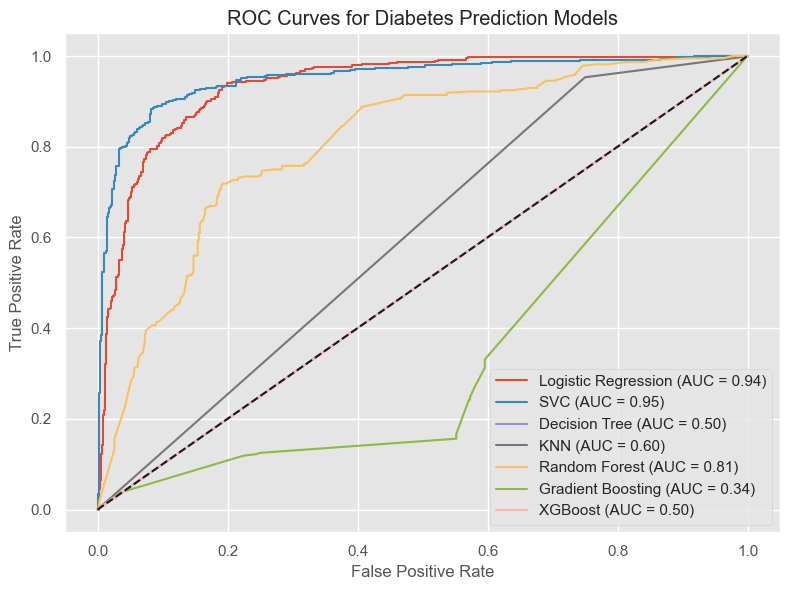

In [ ]:
plt.figure(figsize=(8, 6))
for name, model in models_eval.items():
    # Use pipelines directly or transform X_test with preprocessor if needed.
    if hasattr(model, "predict_proba"):
        probas_ = model.predict_proba(X_test)[:, 1]
    else:
        probas_ = model.predict(preprocessor.transform(X_test))
    fpr, tpr, _ = roc_curve(y_test, probas_)
    auc_val = roc_auc_score(y_test, probas_)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_val:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Diabetes Prediction Models")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("roc_diabetes.jpeg", format="jpeg", dpi=300)
plt.show()